In [1]:
#import packages
import copy
import datetime
import pandas as pd
import numpy as np
import scipy

In [2]:
from textblob import TextBlob

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style( 'whitegrid' )

# Parameters

In [4]:
pm = dict(
    ## Data choices
    key_word = 'google',
    word_count_threshold = 1,
    
    ## Analysis choices
    # Offset relative to publication for summary
    h = 4,
    # Same but for visualization
    h_max = 14,
    # For normalizing the close
    n_random_times = 1000,
    # Polarity and subjectivity groupings
    cuts = [ 'low', 'mid', 'high' ],
    
    ## Viz choices
    # Spacing for histograms of closing values
    bin_size_close = 5,
    n_overplot = 3,
    seed = 1452,
)

In [5]:
h = pm['h']

In [6]:
rng = np.random.default_rng(pm['seed'])

In [7]:
pm['n_cut_quantiles'] = len( pm['cuts'] )

# Load Data

In [8]:
#upload media.csv and markets.csv
media_data = pd.read_csv("../test_data/media_large.csv", index_col = 0, parse_dates = ['pub_date'])
markets_data = pd.read_csv("../test_data/markets.csv", parse_dates = ['Date'])
markets_data['Date'] = pd.to_datetime( markets_data['Date'], utc=True )
media_data.info()
markets_data.info() #unable to convert Date into datetime64 format

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   pub_date        361 non-null    datetime64[ns, UTC]
 1   abstract        361 non-null    object             
 2   lead_paragraph  361 non-null    object             
 3   snippet         359 non-null    object             
 4   headline.main   361 non-null    object             
 5   text            361 non-null    object             
 6   polarity        361 non-null    float64            
 7   subjectivity    361 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(5)
memory usage: 25.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          209 non-null    

## Add an adjusted close column
This more-closely tracks the actual stock value. In many cases it's identical to close.

In [9]:
markets_data['AdjClose'] = markets_data['Close'] - markets_data['Dividends'] - markets_data['Stock Splits']

## Toss media data with an insufficient word count
This uses the functions Michael added, just in a slightly different way

In [10]:
inds_to_drop = []
for i in range (len(media_data['text'])):
    blob = TextBlob(media_data.loc[i,'text'])
    if blob.word_counts[pm['key_word']] < pm['word_count_threshold']:
        inds_to_drop.append( i )

In [11]:
media_data.drop( inds_to_drop, inplace=True )

## Group media data by polarity and subjectivity

In [12]:
media_data['polarity_cut'] = pd.qcut( media_data['polarity'], pm['n_cut_quantiles'], precision=2 )
media_data_polarity_counts = media_data.value_counts( 'polarity_cut' )

In [13]:
media_data['subjectivity_cut'] = pd.qcut( media_data['subjectivity'], pm['n_cut_quantiles'], precision=2 )
media_data_subjectivity_counts = media_data.value_counts( 'subjectivity_cut' )

In [14]:
get_combined_cut = lambda row: (
        polarity_categories.get_loc( row['polarity_cut'] ),
        subjectivity_categories.get_loc( row['subjectivity_cut'] )
    )

In [15]:
# For the combination we tweak the column names to make less messy.
polarity_categories = media_data['polarity_cut'].values.categories
subjectivity_categories = media_data['subjectivity_cut'].values.categories
media_data['combined_cut'] = media_data.apply( get_combined_cut, axis=1 )
media_data_combined_counts = media_data.value_counts( 'combined_cut' )

In [16]:
media_data_combined = media_data.groupby( 'combined_cut' )

# Stock vs time of publication

## Organize Data

### Stacked data

In [17]:
times = []
closings = []
closing_diffs = []
columns_to_tile = [
    'polarity',
    'subjectivity',
    'polarity_cut',
    'subjectivity_cut',
]
tiled_columns = {}

i_broken = []

# Loop through and gather offset data
pub_dates = media_data['pub_date'].dt.date
for i in media_data.index:
    
    pub_date = pub_dates.loc[i]
    
    # Time relative to publication
    time_offset = ( markets_data['Date'].dt.date - pub_date ) / pd.Timedelta( 1, 'day' )
    # and boolean array indicating what's in range
    is_in_range = (
        ( time_offset > -pm['h_max'] )
        & ( time_offset < pm['h_max'] )
    )
    
    # Get values
    time_offset_stored = time_offset.loc[is_in_range]
    closing = markets_data['AdjClose'].loc[is_in_range]
    
    # Center the closing on the time the article is published to focus on changes
    try:
        closing_tpub = scipy.interpolate.interp1d( time_offset_stored, closing )( 0 )
    except ValueError:
        i_broken.append( i )
        continue
    closing_diff = closing - closing_tpub 
    
    # Store data
    times.append( time_offset_stored )
    closings.append( closing )
    closing_diffs.append( closing_diff )
    
    # We project these into an array for consistent array sizes, useful for later filtering of data
    for column in columns_to_tile:
        if column not in tiled_columns:
            tiled_columns[column] = []
        if column != 'combined_cut':
            tiled_columns[column].append( np.full( closing.shape, media_data.loc[i,column] ) )
        else:
            tiled_columns[column].append( np.full( ( closing.size, 2), media_data.loc[i,column] ) )

In [18]:
stacked_data = {
    't_rel_tpub': np.hstack( times ),
    'adj_close': np.hstack( closings ),
    'adj_close_diff': np.hstack( closing_diffs ),
}
for column, item in tiled_columns.items():
    stacked_data[column] = np.concatenate( item, axis=0 )
stacked = pd.DataFrame( data=stacked_data )

### Random data

In [19]:
# Choose as many random offsets as there are publications, for similar counts
t_rand = rng.choice( markets_data['Date'], pm['n_random_times'] )

In [20]:
random_times = []
random_closings = []
random_closing_diffs = []

# Loop through and gather offset data
for i, t_rand in enumerate( t_rand ):
    
    # Time relative to publication
    time_offset = ( markets_data['Date'] - t_rand ) / pd.Timedelta( 1, 'day' )
    # and boolean array indicating what's in range
    is_in_range = (
        ( time_offset > -pm['h_max'] )
        & ( time_offset < pm['h_max'] )
    )
    
    # Get values
    time_offset_stored = time_offset.loc[is_in_range]
    closing = markets_data['AdjClose'].loc[is_in_range]
    
    # Center the closing on the time the article is published to focus on changes
    closing_tpub = scipy.interpolate.interp1d( time_offset_stored, closing )( 0 )
    closing_diff = closing - closing_tpub 
    
    # Store data
    random_times.append( time_offset_stored )
    random_closings.append( closing )
    random_closing_diffs.append( closing_diff )

In [21]:
random = pd.DataFrame(
    data={
        't_rel_trand': np.hstack( random_times ),
        'adj_close': np.hstack( random_closings ),
        'adj_close_diff': np.hstack( random_closing_diffs ),
    }
)

### Viz of Polarities, Subjectivities

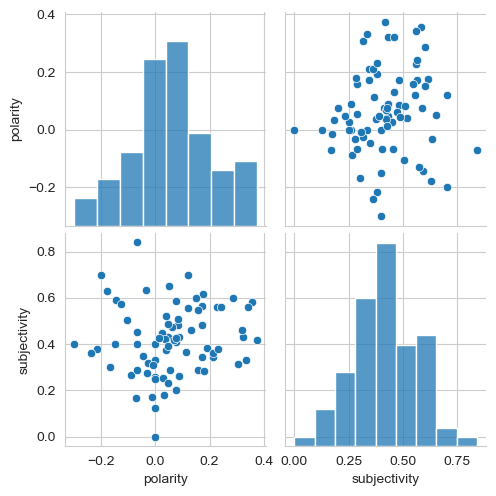

In [22]:
sns.pairplot(
    media_data,
    x_vars = [ 'polarity', 'subjectivity' ],
)

### Group by Both Polarity and Subjectivity

In [23]:
stacked_polarity = stacked.groupby( 'polarity_cut' )
stacked_subjectivity = stacked.groupby( 'subjectivity_cut' )

In [24]:
# Combined is obnoxious because it includes tuples.
stacked['combined_cut'] = stacked.apply( get_combined_cut, axis=1 )
stacked_combined = stacked.groupby( 'combined_cut' )

## Adjusted close vs $t - t_{\rm pub}$

In [25]:
# Make histogram bins
time_bins = np.arange( -pm['h_max'] - 0.5, pm['h_max'] + 1.5 )
close_bins = np.arange( 0, markets_data['AdjClose'].max() + pm['bin_size_close'], pm['bin_size_close'] )

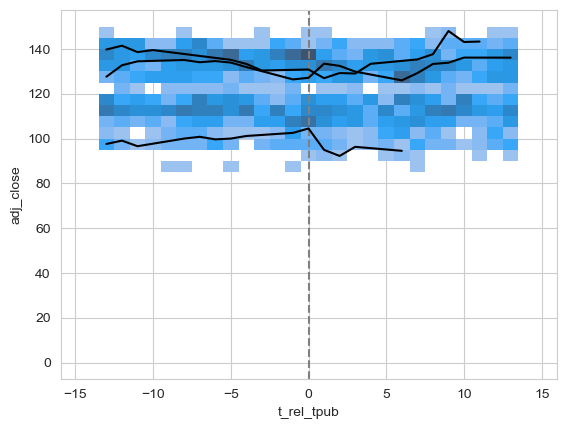

In [26]:
fig = plt.figure()
ax = plt.gca()

sns.histplot(
    data=stacked,
    x='t_rel_tpub',
    y='adj_close',
    bins = ( time_bins, close_bins ),
    ax = ax,
)

ax.axvline(
    0,
    color = '0.5',
    linestyle = '--',
)

# Plot n_overplotted individual histories
i_pubs = rng.choice( range(len(times)), pm['n_overplot'] )
for i in i_pubs:
    ax.plot(
        times[i],
        closings[i],
        color = 'k',
    )

No strong trend yet, but let's center and compare to random.

## ( Adj close - Adj close @ $t_{\rm pub}$ ) vs $t - t_{\rm pub}$

In [27]:
# Make histogram bins for difference in close
# This could be simplified to
# np.arange( stacked['adj_close_diff'].min(), stacked['adj_close_diff'].max() + pm['bin_size_close'], pm['bin_size_close'] )
# But I wanted even bins centered on 0
adj_close_diff_max = np.abs( stacked['adj_close_diff'] ).max()
diff_bins_onesided = np.arange( 0, adj_close_diff_max + pm['bin_size_close'], pm['bin_size_close'] )
diff_bins = np.hstack( [ -diff_bins_onesided[::-1][:-1], diff_bins_onesided ] )

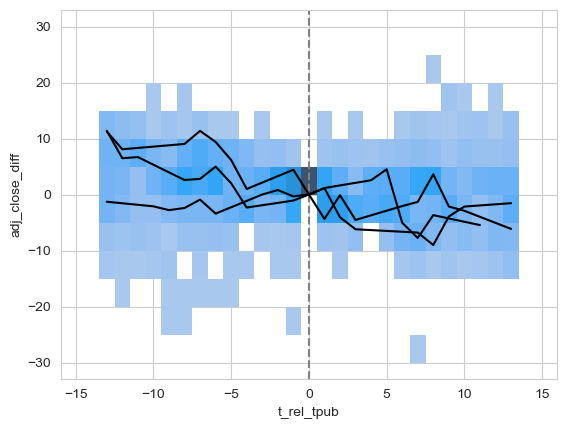

In [28]:
fig = plt.figure()
ax = plt.gca()

sns.histplot(
    data=stacked,
    x='t_rel_tpub',
    y='adj_close_diff',
    bins = ( time_bins, diff_bins ),
    ax = ax,
)

ax.axvline(
    0,
    color = '0.5',
    linestyle = '--',
)

# Plot n_overplotted individual histories
i_pubs = rng.choice( range(len(times)), pm['n_overplot'] )
for i in i_pubs:
    ax.plot(
        times[i],
        closing_diffs[i],
        color = 'k',
    )

All right! Now we can see a trend show up. But we need something to compare this to.

## ( Adj close - Adj close @ $t_{\rm rand}$ ) vs $t - t_{\rm rand}$

In [29]:
ax = sns.histplot(
    data=random,
    x='t_rel_trand',
    y='adj_close_diff',
    bins = ( time_bins, diff_bins ),
    ax = ax,
)

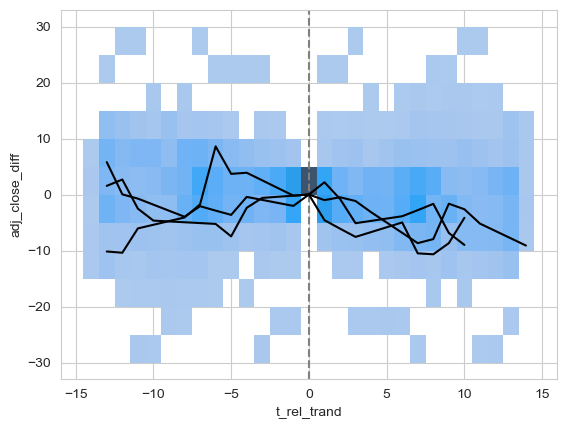

In [30]:
fig = plt.figure()
ax = plt.gca()

sns.histplot(
    data=random,
    x='t_rel_trand',
    y='adj_close_diff',
    bins = ( time_bins, diff_bins ),
    ax = ax,
)

ax.axvline(
    0,
    color = '0.5',
    linestyle = '--',
)

# Plot n_overplotted individual histories
i_pubs = rng.choice( media_data.index, pm['n_overplot'] )
for i in i_pubs:
    ax.plot(
        random_times[i],
        random_closing_diffs[i],
        color = 'k',
    )

As we can see, there is still a trend for random times, probably because there's an average change for the stock over the course of the time period 

## Excess Probability vs $t - t_{\rm pub}$

That is, $P\left( \Delta A ( t - t_i ) \mid t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}\right) -
P\left( \Delta A ( t - t_i ) \mid t_i {\rm\,is\,random} \right)$

### Perform normalization

In [31]:
# First histogram bins
time_bins = np.arange( -pm['h_max'] - 0.5, pm['h_max'] + 1.5 )

# This time we take the extreme of both the stacked and random
adj_close_diff_max = np.abs( np.hstack( [ stacked['adj_close_diff'], random['adj_close_diff'] ] ) ).max()
diff_bins_onesided = np.arange( 0, adj_close_diff_max + pm['bin_size_close'], pm['bin_size_close'] )
diff_bins = np.hstack( [ -diff_bins_onesided[::-1][:-1], diff_bins_onesided ] )

In [32]:
# Now histograms
dist, _, _ = np.histogram2d(
    stacked['t_rel_tpub'],
    stacked['adj_close_diff'],
    bins = ( time_bins, diff_bins ),
    density = True,
)
dist_random, _, _ = np.histogram2d(
    random['t_rel_trand'],
    random['adj_close_diff'],
    bins = ( time_bins, diff_bins ),
    density = True,
)

In [33]:
# Normalize relative to probability on that day
dist /= dist.sum( axis=1 )[:,np.newaxis]
dist_random /= dist_random.sum( axis=1 )[:,np.newaxis]

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_59114/3835702599.py:2: RuntimeWarning: invalid value encountered in divide
  dist /= dist.sum( axis=1 )[:,np.newaxis]


In [34]:
# Make a relative value array
adj_close_normalized = dist - dist_random
norm_max_diff = np.nanmax( np.abs( adj_close_normalized ) )

### For all publications

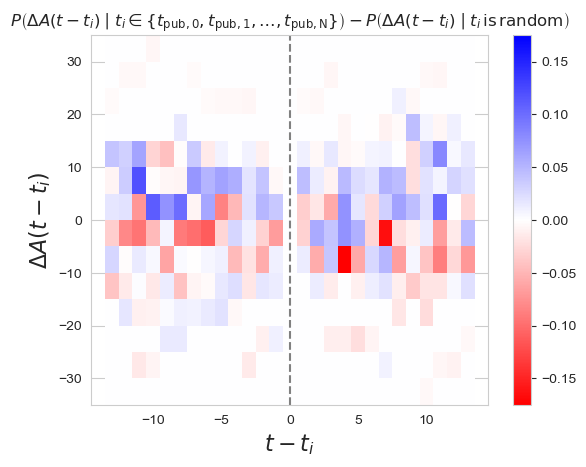

In [35]:
fig = plt.figure()
ax = plt.gca()

img = ax.pcolormesh(
    time_bins,
    diff_bins,
    adj_close_normalized.transpose(),
    cmap = 'bwr_r',
    vmin = -norm_max_diff,
    vmax = norm_max_diff,
)

ax.axvline(
    0,
    color = '0.5',
    linestyle = '--',
)

ax.set_xlabel(
    r'$t - t_i$',
    fontsize = 16
)

ax.set_ylabel(
    r'$\Delta A(t - t_i)$',
    fontsize = 16
)

ax.set_title(
    r'$P\left( \Delta A ( t - t_i ) \mid t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}\right) - P\left( \Delta A ( t - t_i ) \mid t_i {\rm\,is\,random} \right)$'
)

fig.colorbar(img)

How to interpret this:
The value in a given bin indicates the difference in probability, relative to random, that the adjusted close of that given day will have the corresponding y-axis value.

The red combined with blue is a little hard to interpret, so let's just focus on _excess_ probability.

In [36]:
adj_close_excess = copy.copy( adj_close_normalized )
adj_close_excess[adj_close_normalized < 0.] = 0.

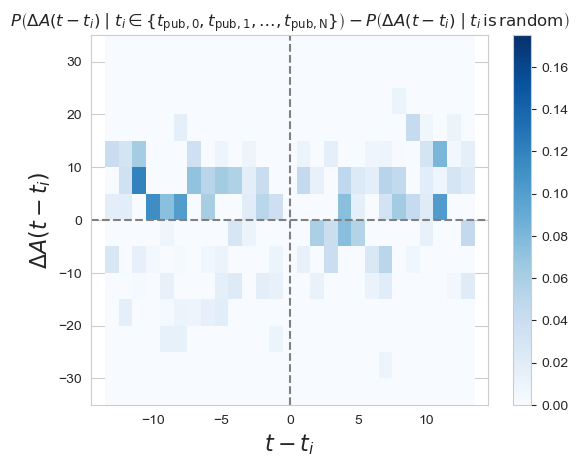

In [37]:
fig = plt.figure()
ax = plt.gca()

img = ax.pcolormesh(
    time_bins,
    diff_bins,
    adj_close_excess.transpose(),
    cmap = 'Blues',
    vmin = 0,
    vmax = norm_max_diff,
)

ax.axvline(
    0,
    color = '0.5',
    linestyle = '--',
)
ax.axhline(
    0,
    color = '0.5',
    linestyle = '--',
)

ax.set_xlabel(
    r'$t - t_i$',
    fontsize = 16
)

ax.set_ylabel(
    r'$\Delta A(t - t_i)$',
    fontsize = 16
)

ax.set_title(
    r'$P\left( \Delta A ( t - t_i ) \mid t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}\right) - P\left( \Delta A ( t - t_i ) \mid t_i {\rm\,is\,random} \right)$'
)

fig.colorbar(img)

Now this is interpretable. It is noisy, but says that if there was an article published at a given date, then up to 14 days prior to that date there's an up-to-10% increase in probability that the stock saw an increase.
The same is true for up to 14 days after.
It may be likely that an article was written

### Per polarity cut

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_59114/380710736.py:14: RuntimeWarning: invalid value encountered in divide
  dist /= dist.sum( axis=1 )[:,np.newaxis]
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_59114/380710736.py:14: RuntimeWarning: invalid value encountered in divide
  dist /= dist.sum( axis=1 )[:,np.newaxis]
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_59114/380710736.py:14: RuntimeWarning: invalid value encountered in divide
  dist /= dist.sum( axis=1 )[:,np.newaxis]


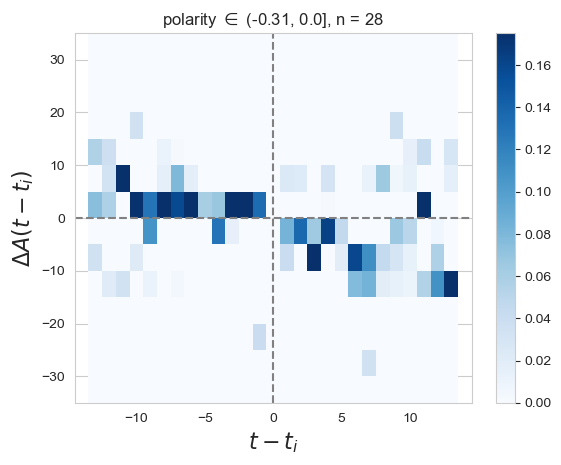

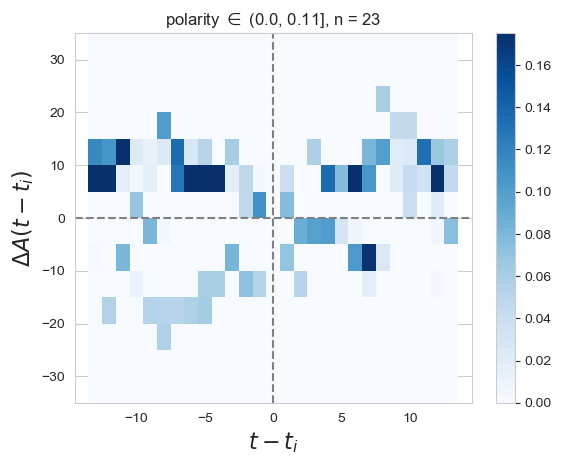

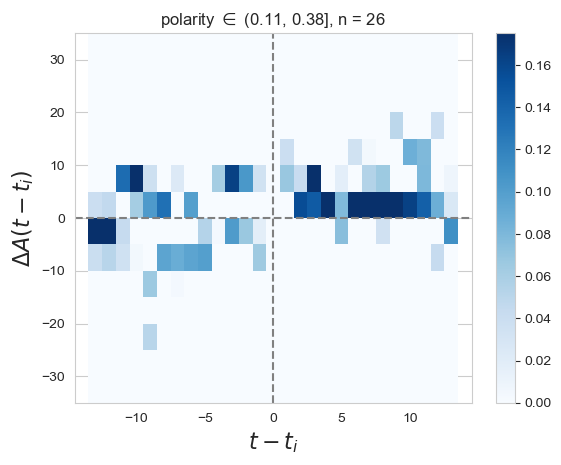

In [38]:
for group_key in stacked_polarity.groups.keys():
    
    group = stacked_polarity.get_group( group_key )
    
    # Now histograms
    dist, _, _ = np.histogram2d(
        group['t_rel_tpub'],
        group['adj_close_diff'],
        bins = ( time_bins, diff_bins ),
        density = True,
    )

    # Normalize relative to probability on that day
    dist /= dist.sum( axis=1 )[:,np.newaxis]

    # Make a relative value array
    adj_close_normalized = dist - dist_random
    
    adj_close_excess = copy.copy( adj_close_normalized )
    adj_close_excess[adj_close_normalized < 0.] = 0.

    fig = plt.figure()
    ax = plt.gca()

    img = ax.pcolormesh(
        time_bins,
        diff_bins,
        adj_close_excess.transpose(),
        cmap = 'Blues',
        vmin = 0,
        vmax = norm_max_diff,
    )

    ax.axvline(
        0,
        color = '0.5',
        linestyle = '--',
    )
    ax.axhline(
        0,
        color = '0.5',
        linestyle = '--',
    )

    ax.set_xlabel(
        r'$t - t_i$',
        fontsize = 16
    )

    ax.set_ylabel(
        r'$\Delta A(t - t_i)$',
        fontsize = 16
    )

    ax.set_title(
        label = (
            r'polarity $\in$ '
            + str( group_key )
            + ', n = {}'.format( media_data_polarity_counts.loc[group_key] )
        )
    )

    fig.colorbar(img)

## Running Medians
An alternative, cleaner perspective

In [39]:
time_centers = 0.5 * ( time_bins[:-1] + time_bins[1:] )

### For all publications

In [40]:
binned_stats = {
    'median': 'median',
    '16th percentile': lambda x: np.nanpercentile( x, 16 ),
    '84th percentile': lambda x: np.nanpercentile( x, 84 ),
}

In [41]:
bsrs = {}
bsr_randoms = {}
for stat_key, stat_fn in binned_stats.items():
    
    bsrs[stat_key] = scipy.stats.binned_statistic(
        stacked['t_rel_tpub'],
        stacked['adj_close_diff'],
        statistic = stat_fn,
        bins = time_bins,
    )
    
    bsr_random = scipy.stats.binned_statistic(
        random['t_rel_trand'],
        random['adj_close_diff'],
        statistic = stat_fn,
        bins = time_bins,
    )
    # Invalid bins
    bsr_random.statistic[0] = np.nan
    bsr_random.statistic[-1] = np.nan
    bsr_randoms[stat_key] = bsr_random

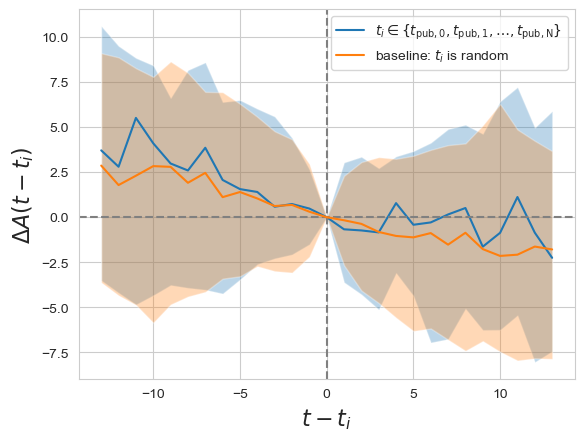

In [42]:
fig = plt.figure()
ax = plt.gca()

ax.plot(
    time_centers,
    bsrs['median'].statistic,
    label = r'$t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}$',
)
ax.fill_between(
    time_centers,
    bsrs['16th percentile'].statistic,
    bsrs['84th percentile'].statistic,
    alpha = 0.3,
)

ax.axvline(
    0,
    color = '0.5',
    linestyle = '--',
)
ax.axhline(
    0,
    color = '0.5',
    linestyle = '--',
)

ax.plot(
    time_centers,
    bsr_randoms['median'].statistic,
    label = r'baseline: $t_i$ is random',
)
ax.fill_between(
    time_centers,
    bsr_randoms['16th percentile'].statistic,
    bsr_randoms['84th percentile'].statistic,
    alpha = 0.3,
)

ax.set_xlabel(
    r'$t - t_i$',
    fontsize = 16
)

ax.set_ylabel(
    r'$\Delta A(t - t_i)$',
    fontsize = 16
)

ax.legend()

### Per polarity cut

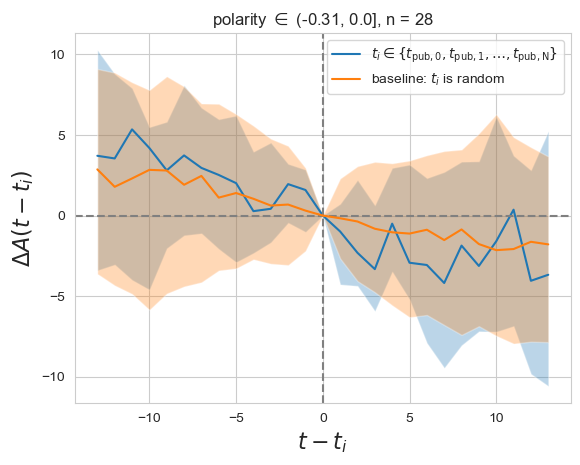

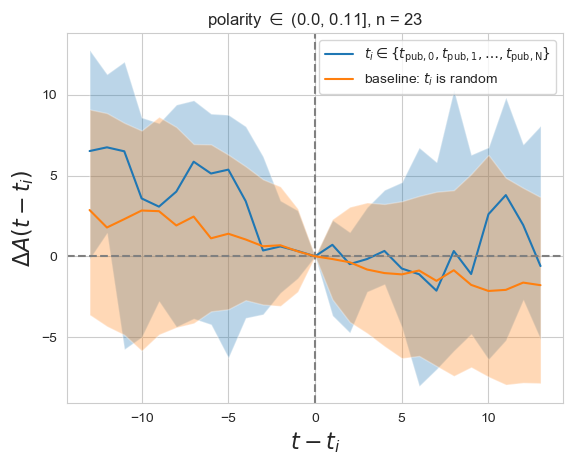

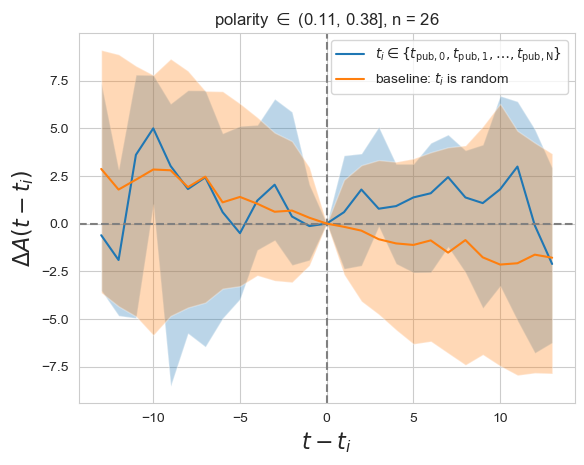

In [43]:
for group_key in stacked_polarity.groups.keys():
    
    group = stacked_polarity.get_group( group_key )

    bsrs = {}
    bsr_randoms = {}
    for stat_key, stat_fn in binned_stats.items():

        bsrs[stat_key] = scipy.stats.binned_statistic(
            group['t_rel_tpub'],
            group['adj_close_diff'],
            statistic = stat_fn,
            bins = time_bins,
        )

        bsr_random = scipy.stats.binned_statistic(
            random['t_rel_trand'],
            random['adj_close_diff'],
            statistic = stat_fn,
            bins = time_bins,
        )
        # Invalid bins
        bsr_random.statistic[0] = np.nan
        bsr_random.statistic[-1] = np.nan
        bsr_randoms[stat_key] = bsr_random

    fig = plt.figure()
    ax = plt.gca()

    ax.plot(
        time_centers,
        bsrs['median'].statistic,
        label = r'$t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}$'
    )
    ax.fill_between(
        time_centers,
        bsrs['16th percentile'].statistic,
        bsrs['84th percentile'].statistic,
        alpha = 0.3,
    )

    ax.axvline(
        0,
        color = '0.5',
        linestyle = '--',
    )
    ax.axhline(
        0,
        color = '0.5',
        linestyle = '--',
    )

    ax.plot(
        time_centers,
        bsr_randoms['median'].statistic,
        label = r'baseline: $t_i$ is random',
    )
    ax.fill_between(
        time_centers,
        bsr_randoms['16th percentile'].statistic,
        bsr_randoms['84th percentile'].statistic,
        alpha = 0.3,
    )

    ax.set_xlabel(
        r'$t - t_i$',
        fontsize = 16
    )

    ax.set_ylabel(
        r'$\Delta A(t - t_i)$',
        fontsize = 16
    )
    
    ax.set_title(
        label = (
            r'polarity $\in$ '
            + str( group_key )
            + ', n = {}'.format( media_data_polarity_counts.loc[group_key] )
        )
    )
    
    ax.legend()

### Per subjectivity cut

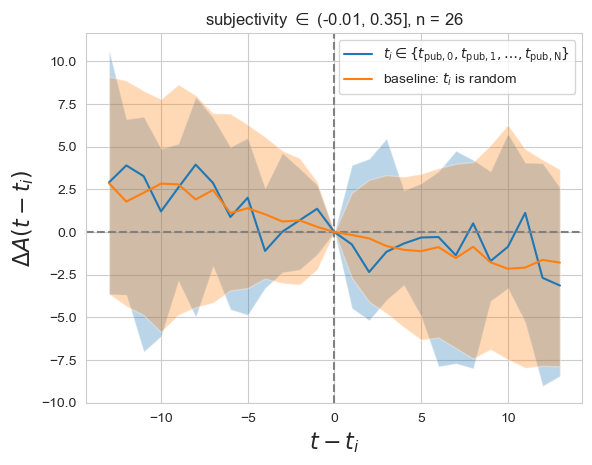

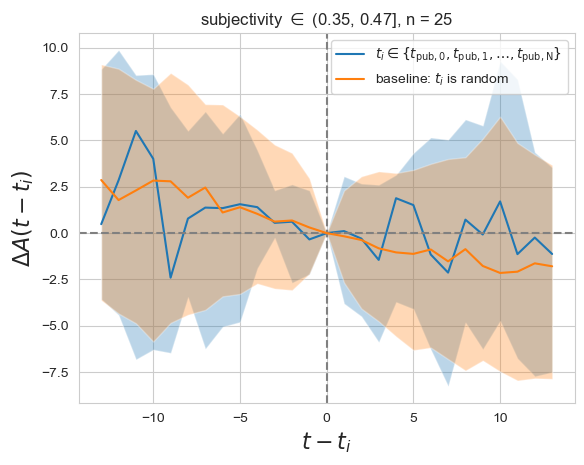

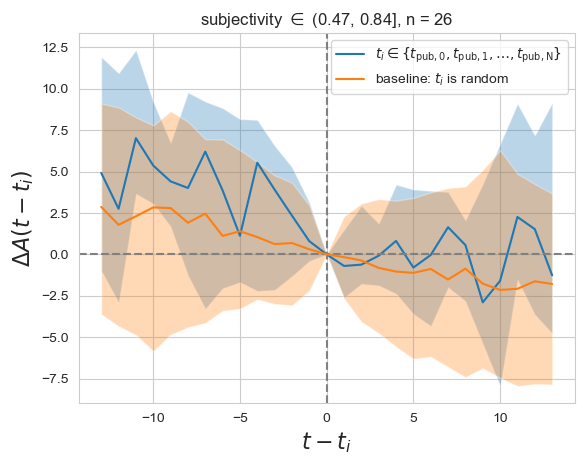

In [44]:
for group_key in stacked_subjectivity.groups.keys():
    
    group = stacked_subjectivity.get_group( group_key )

    bsrs = {}
    bsr_randoms = {}
    for stat_key, stat_fn in binned_stats.items():

        bsrs[stat_key] = scipy.stats.binned_statistic(
            group['t_rel_tpub'],
            group['adj_close_diff'],
            statistic = stat_fn,
            bins = time_bins,
        )

        bsr_random = scipy.stats.binned_statistic(
            random['t_rel_trand'],
            random['adj_close_diff'],
            statistic = stat_fn,
            bins = time_bins,
        )
        # Invalid bins
        bsr_random.statistic[0] = np.nan
        bsr_random.statistic[-1] = np.nan
        bsr_randoms[stat_key] = bsr_random

    fig = plt.figure()
    ax = plt.gca()

    ax.plot(
        time_centers,
        bsrs['median'].statistic,
        label = r'$t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}$'
    )
    ax.fill_between(
        time_centers,
        bsrs['16th percentile'].statistic,
        bsrs['84th percentile'].statistic,
        alpha = 0.3,
    )

    ax.axvline(
        0,
        color = '0.5',
        linestyle = '--',
    )
    ax.axhline(
        0,
        color = '0.5',
        linestyle = '--',
    )

    ax.plot(
        time_centers,
        bsr_randoms['median'].statistic,
        label = r'baseline: $t_i$ is random',
    )
    ax.fill_between(
        time_centers,
        bsr_randoms['16th percentile'].statistic,
        bsr_randoms['84th percentile'].statistic,
        alpha = 0.3,
    )

    ax.set_xlabel(
        r'$t - t_i$',
        fontsize = 16
    )

    ax.set_ylabel(
        r'$\Delta A(t - t_i)$',
        fontsize = 16
    )
    
    ax.set_title(
        label = (
            r'subjectivity $\in$ '
            + str( group_key )
            + ', n = {}'.format( media_data_subjectivity_counts.loc[group_key] )
        )
    )
    
    ax.legend()

### Per combined cut

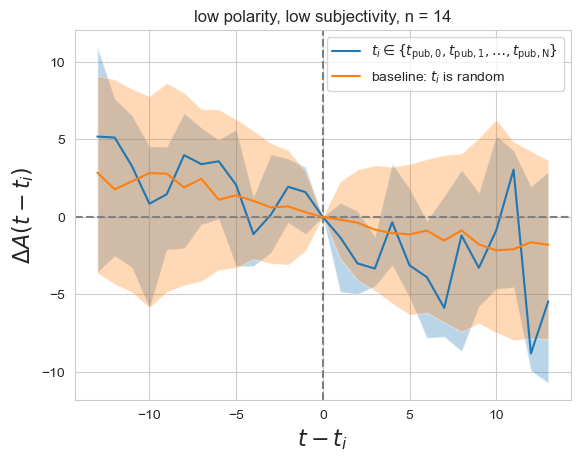

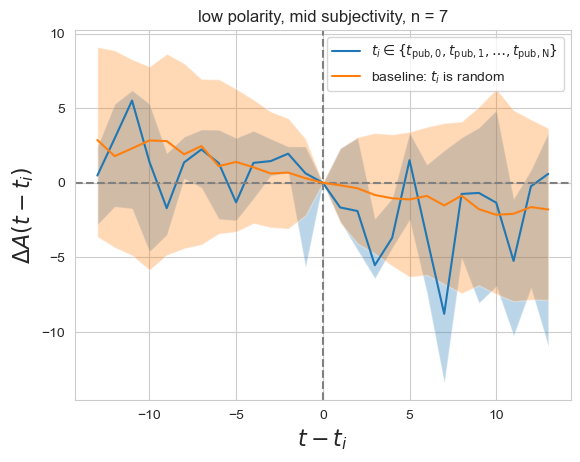

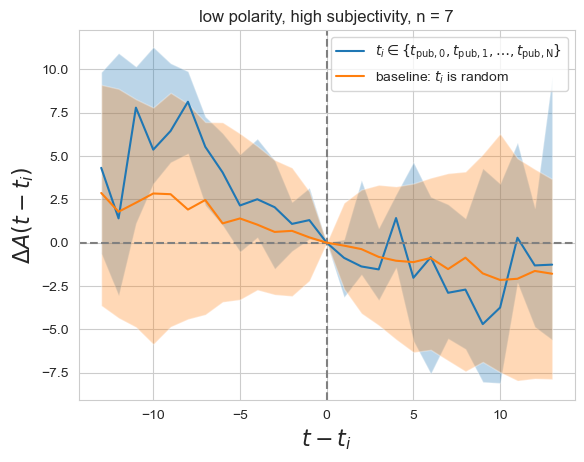

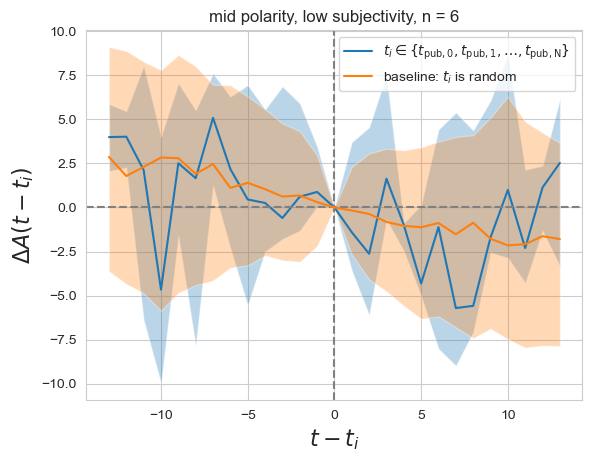

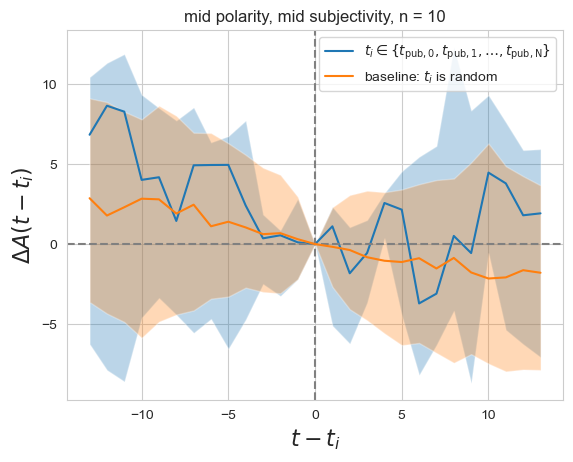

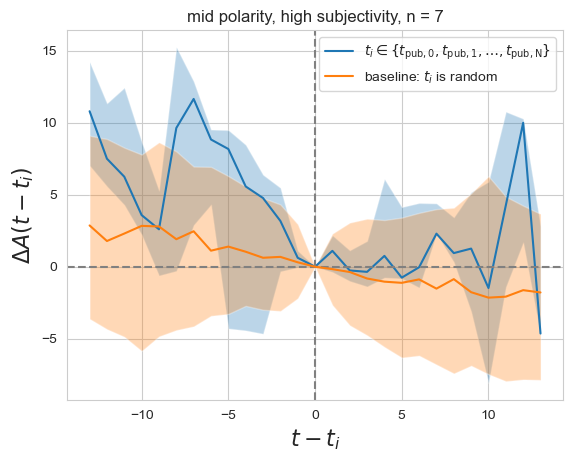

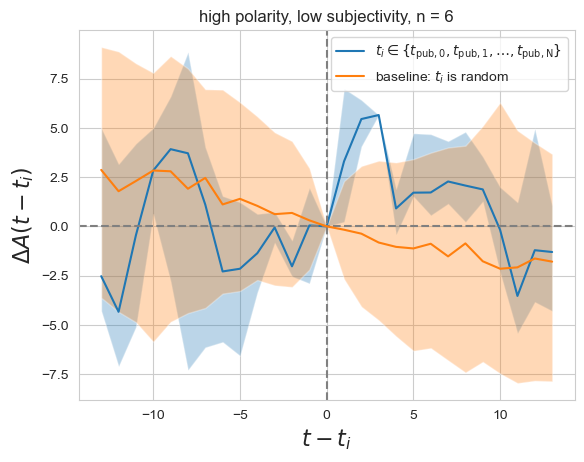

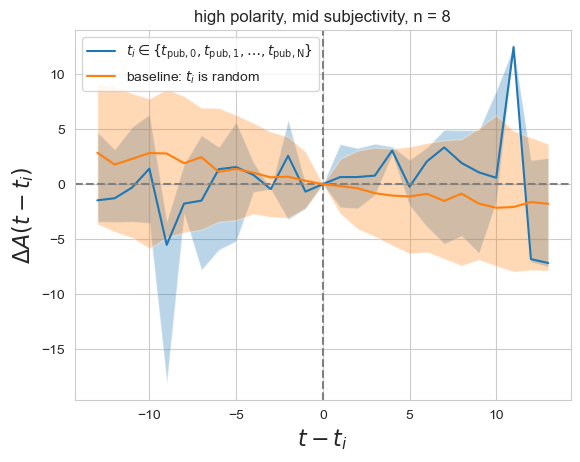

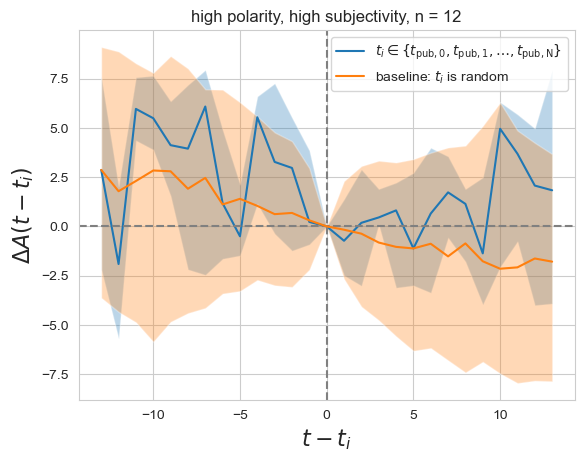

In [46]:
for group_key in stacked_combined.groups.keys():
    
    group = stacked_combined.get_group( group_key )

    bsrs = {}
    bsr_randoms = {}
    for stat_key, stat_fn in binned_stats.items():

        bsrs[stat_key] = scipy.stats.binned_statistic(
            group['t_rel_tpub'],
            group['adj_close_diff'],
            statistic = stat_fn,
            bins = time_bins,
        )

        bsr_random = scipy.stats.binned_statistic(
            random['t_rel_trand'],
            random['adj_close_diff'],
            statistic = stat_fn,
            bins = time_bins,
        )
        # Invalid bins
        bsr_random.statistic[0] = np.nan
        bsr_random.statistic[-1] = np.nan
        bsr_randoms[stat_key] = bsr_random

    fig = plt.figure()
    ax = plt.gca()

    ax.plot(
        time_centers,
        bsrs['median'].statistic,
        label = r'$t_i \in \{ t_{\rm pub,0}, t_{\rm pub,1}, \ldots, t_{\rm pub,N} \}$'
    )
    ax.fill_between(
        time_centers,
        bsrs['16th percentile'].statistic,
        bsrs['84th percentile'].statistic,
        alpha = 0.3,
    )

    ax.axvline(
        0,
        color = '0.5',
        linestyle = '--',
    )
    ax.axhline(
        0,
        color = '0.5',
        linestyle = '--',
    )

    ax.plot(
        time_centers,
        bsr_randoms['median'].statistic,
        label = r'baseline: $t_i$ is random',
    )
    ax.fill_between(
        time_centers,
        bsr_randoms['16th percentile'].statistic,
        bsr_randoms['84th percentile'].statistic,
        alpha = 0.3,
    )

    ax.set_xlabel(
        r'$t - t_i$',
        fontsize = 16
    )

    ax.set_ylabel(
        r'$\Delta A(t - t_i)$',
        fontsize = 16
    )
    
    ax.set_title(
        label = '{} polarity, {} subjectivity, n = {}'.format(
            pm['cuts'][group_key[0]],
            pm['cuts'][group_key[1]],
            len( media_data_combined.get_group( group_key ) )
        )
    )
    
    ax.legend()